# Cluster Analysis

## 대출 이력 여부에 대한 유저 확인

In [1]:
# 필요 라이브러리 호출

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 

import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm

In [2]:
log_data = pd.read_csv("./../data/log_data_pre") # log_data에 대해서 전처리한 데이터를 사용 (결측치 대체, 행동명 매핑, 행동일시 slicing)
log_data = log_data.drop("Unnamed: 0",axis=1)
user_spec = pd.read_csv("./../data/user_spec.csv") 
loan_result = pd.read_csv("./../data/loan_result.csv")

In [3]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

In [4]:
print(log_data.columns)
print(user_spec.columns)
print(loan_result.columns)

Index(['유저_번호', '행동명', '행동명_kor', '행동일시', '운영체제', '앱_버전', '일_코드', '년', '월',
       '일', '시', '분', '초'],
      dtype='object')
Index(['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득',
       '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부',
       '개인회생자_납입_완료_여부', '기대출수', '기대출금액'],
      dtype='object')
Index(['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)'], dtype='object')


In [5]:
# loan_result 에서 신청_여부 nan 값인 6월 제거
loan_result_t = loan_result.dropna( subset=['신청_여부(y)'] )
loan_result_t.isnull().sum()

신청서_번호         0
한도조회_일시        0
금융사_번호         0
상품_번호          0
승인한도        5738
승인금리        5738
신청_여부(y)       0
dtype: int64

In [6]:
loan_result_u = loan_result_t.groupby("신청서_번호").sum()["신청_여부(y)"]
print(loan_result_u.head())
print(loan_result_u.isnull().sum())

신청서_번호
1     0.0
2     0.0
6     0.0
14    3.0
17    1.0
Name: 신청_여부(y), dtype: float64
0


In [7]:
# user_spec 에서도 6월분 제외

user_spec_t = user_spec
user_spec_t["월"] = user_spec_t["생성일시"].str.slice(start=6, stop=7)
user_spec_t = user_spec_t[user_spec_t["월"] != "6"]

In [8]:
a = pd.merge(user_spec_t[["유저_번호","신청서_번호","생성일시"]].drop_duplicates(), loan_result_u, on = "신청서_번호", how = "left")

print(a["신청_여부(y)"].unique())
print(a.head())

a = a.fillna(-1) # 여기서 null 값은 이탈 하거나 모두 거절된 case

a.rename(columns={'신청_여부(y)':'신청_횟수'},inplace = True)
a.sort_values(["유저_번호","신청서_번호"]).head()

[ 0. nan  4.  1.  3.  2.  7.  6.  5. 10.  8.  9. 11. 12. 13. 14. 20. 16.
 15. 19. 18. 22. 17.]
    유저_번호   신청서_번호                 생성일시  신청_여부(y)
0  836762  1945260  2022-04-20 01:23:09       0.0
1    8623  1384503  2022-04-20 18:51:40       NaN
2  379488  1617530  2022-04-20 10:08:40       NaN
3  186886  1019382  2022-04-20 00:38:18       4.0
4  594274  1117343  2022-04-20 15:01:01       1.0


,유저_번호,신청서_번호,생성일시,신청_횟수
954332,1,1031304,2022-05-03 14:51:00,-1.0
954333,1,1767402,2022-05-03 14:53:33,-1.0
719476,7,1096882,2022-05-22 16:42:47,-1.0
851798,9,248576,2022-05-21 23:41:09,0.0
262749,11,1180616,2022-03-24 10:58:22,2.0


In [9]:
# 신청 횟수에 음수/양수 모두 갖고 있는 유저 확인
# 문제 : 신청서 기준으로 하다 보니까, 어떤 신청서는 전부 거절 됐을 수도 있고 어떤 유저는 아예 이탈해서 -1 찍히는 걸수도 있는데. 이걸 판단하기가 어렵네.
# A 유저는 전부 거절된 신청서도 있고, 신청한 신청서도 있고
# B 유저는 전부 이탈해서 아예 다 -1 로 찍힐 수도 있고 
# 그럼 A 유저의 경우는 전부 거절된 유저로 봐야하는지 신청한 유저로 봐야하는지? 
# 일단 MAX 로 해서 A 의 경우는 신청한 유저로 갑니다.

plus = a[a["신청_횟수"]>=0]
minus = a[a["신청_횟수"]<0]

user_list = plus[plus["유저_번호"].isin(minus["유저_번호"])]["유저_번호"]

print("아래 출력되는 리스트는 어떤 신청서는 모두 거절되고, 어떤 신청서는 또 존재하는 CASE")
a[a["유저_번호"].isin(user_list)].sort_values("유저_번호").head()

아래 출력되는 리스트는 어떤 신청서는 모두 거절되고, 어떤 신청서는 또 존재하는 CASE


,유저_번호,신청서_번호,생성일시,신청_횟수
985915,14,1304798,2022-05-16 13:04:26,-1.0
72720,14,1508745,2022-04-18 14:37:09,0.0
712360,19,726760,2022-05-14 00:56:19,-1.0
457060,19,1854180,2022-05-06 17:10:55,0.0
784974,45,56229,2022-03-13 07:11:34,-1.0


In [10]:
print(user_spec[user_spec["유저_번호"]==14])
print("---")
print(loan_result[loan_result["신청서_번호"]==1508745]) # 1508745 는 조회 이력은 있고, 신청은 하지 않음 
print("---")
print(loan_result[loan_result["신청서_번호"]==1304798]) # 1304798 는 아예 loan_result 에서 조회 되지 않음.

          신청서_번호  유저_번호  유저_생년월일  유저_성별                 생성일시  한도조회_당시_유저_신용점수  \
101480   1508745     14   1965.0    0.0  2022-04-18 14:37:09              NaN   
1334800  1304798     14   1965.0    0.0  2022-05-16 13:04:26              NaN   

                연소득          근로형태      입사연월 고용형태 주거소유형태      대출희망금액  \
101480   27000000.0  EARNEDINCOME  202004.0  정규직    전월세  30000000.0   
1334800  26000000.0  EARNEDINCOME  202004.0  정규직    전월세  20000000.0   

              대출_목적  개인회생자_여부  개인회생자_납입_완료_여부  기대출수  기대출금액  월  
101480   SWITCHLOAN       NaN             NaN   NaN    NaN  4  
1334800  SWITCHLOAN       NaN             NaN   NaN    NaN  5  
---
          신청서_번호              한도조회_일시  금융사_번호  상품_번호        승인한도  승인금리  \
2308117  1508745  2022-04-18 14:37:10      17     19  27000000.0  13.7   
2308118  1508745  2022-04-18 14:37:11      37    206   8000000.0  19.9   

         신청_여부(y)  
2308117       0.0  
2308118       0.0  
---
Empty DataFrame
Columns: [신청서_번호, 한도조회_일시, 금융사_번호, 상품_번호, 승

In [11]:
# 일단 MAX 로 해서 A 의 경우는 신청한 유저로 갑니다.

b = a.groupby("유저_번호").max("신청_횟수").reset_index()
b.sort_values("신청_횟수").head()

,유저_번호,신청서_번호,신청_횟수
0,1,1767402,-1.0
210214,560015,2007234,-1.0
210215,560016,1562506,-1.0
210216,560019,577560,-1.0
210218,560022,145467,-1.0


In [12]:
b.loc[b["신청_횟수"] > 0 , "신청_종류"] = 3 # 3의 경우는 1번이라도 대출 신청 이력이 있는 경우
b.loc[b["신청_횟수"] == 0 , "신청_종류"] = 2 # 2의 경우는 대출 조회 이력은 있으나, 대출 신청이 0 회인 경우
b.loc[b["신청_횟수"] < 0 , "신청_종류"] = 1 # 1의 경우는 중간에 이탈하거나, 모든 대출 조회 이력에서 모두 거절된 경우

user_loan_result = b[["유저_번호","신청_종류"]]
user_loan_result

,유저_번호,신청_종류
0,1,1.0
1,7,1.0
2,9,2.0
3,11,3.0
4,12,1.0
...,...,...
330188,879693,3.0
330189,879694,1.0
330190,879695,3.0
330191,879696,3.0


In [13]:
# 3의 경우는 1번이라도 대출 신청 이력이 있는 경우
# 2의 경우는 대출 조회 이력은 있으나, 대출 신청이 0 회인 경우
# 1의 경우는 중간에 이탈하거나, 모든 대출 조회 이력에서 모두 거절된 경우

# 0 -> 로그만 있고 

user_loan_result.groupby("신청_종류")["유저_번호"].count()

신청_종류
1.0     70865
2.0     82655
3.0    176673
Name: 유저_번호, dtype: int64

## 유저별 파생 변수 병합

In [14]:
app_id_cnt = user_spec_t.groupby("유저_번호")["신청서_번호"].nunique().reset_index() # 고유 신청서 번호 횟수
app_id_cnt.columns = ("유저_번호","신청서_갯수")
app_id_cnt.head()

,유저_번호,신청서_갯수
0,1,2
1,7,1
2,9,1
3,11,2
4,12,10


In [15]:
loan_result_cnt = loan_result_t.groupby("신청서_번호")["신청_여부(y)"].sum().reset_index()
loan_result_cnt.columns = ("신청서_번호", "신청_갯수")

temp = user_spec_t[["유저_번호","신청서_번호"]].drop_duplicates()

loan_result_cnt = pd.merge(temp, loan_result_cnt, on = "신청서_번호", how = "left")
loan_result_cnt["신청_갯수"] = loan_result_cnt["신청_갯수"].fillna(0) # 신청 갯수 null 인 경우는 이탈/모두 거절 -> 갯수에는 영향을 미치면 안되므로 0 으로 대체
loan_result_cnt.head()

loan_result_cnt= loan_result_cnt.groupby("유저_번호")["신청_갯수"].sum().reset_index()

In [16]:
loan_result_cnt.groupby("신청_갯수").count()

,유저_번호
신청_갯수,
0.0,153520
1.0,69200
2.0,37128
3.0,22128
4.0,13870
...,...
91.0,1
94.0,1
95.0,1


In [17]:
loan_result_cnt

,유저_번호,신청_갯수
0,1,0.0
1,7,0.0
2,9,0.0
3,11,3.0
4,12,0.0
...,...,...
330188,879693,2.0
330189,879694,0.0
330190,879695,1.0
330191,879696,3.0


### 해당 계산 맞는지 함수 활용하여 각각 확인

In [18]:
def check(user_id) :
    app_list = list(user_spec_t[user_spec_t["유저_번호"]==user_id]["신청서_번호"])
    result_list = loan_result_t[loan_result_t["신청서_번호"].isin(app_list)]
    return print(len(set(app_list))),print(result_list["신청_여부(y)"].sum())
    
check(9)

1
0.0


(None, None)

## 데이터 병합
- user_loan_result (유저별_신청_중류), app_id_cnt (유저별_신청서_갯수),loan_result_cnt(유저별_신청_갯수) 병합

In [19]:
print("user_loan_result: ")
print(user_loan_result.head())
print(len(user_loan_result))
print("---------------------")
print("app_id_cnt: ")
print(app_id_cnt.head())
print(len(app_id_cnt))
print("---------------------")
print("loan_result_cnt: ")
print(loan_result_cnt.head())
print(len(loan_result_cnt))

user_loan_result: 
   유저_번호  신청_종류
0      1    1.0
1      7    1.0
2      9    2.0
3     11    3.0
4     12    1.0
330193
---------------------
app_id_cnt: 
   유저_번호  신청서_갯수
0      1       2
1      7       1
2      9       1
3     11       2
4     12      10
330193
---------------------
loan_result_cnt: 
   유저_번호  신청_갯수
0      1    0.0
1      7    0.0
2      9    0.0
3     11    3.0
4     12    0.0
330193


In [20]:
temp = pd.merge(user_loan_result, app_id_cnt, on = "유저_번호", how = "left")
df_merge = pd.merge(temp, loan_result_cnt, on = "유저_번호", how = "left")
df_merge

,유저_번호,신청_종류,신청서_갯수,신청_갯수
0,1,1.0,2,0.0
1,7,1.0,1,0.0
2,9,2.0,1,0.0
3,11,3.0,2,3.0
4,12,1.0,10,0.0
...,...,...,...,...
330188,879693,3.0,3,2.0
330189,879694,1.0,1,0.0
330190,879695,3.0,1,1.0
330191,879696,3.0,2,3.0


In [21]:
df_merge.isnull().sum()

유저_번호     0
신청_종류     0
신청서_갯수    0
신청_갯수     0
dtype: int64

In [22]:
user_log = pd.read_csv("../data/action_cnt_app_open_6_ext.csv")
user_log.drop("Unnamed: 0",axis=1,inplace = True)
user_log.drop("전체_이벤트_x",axis=1,inplace = True)
user_log.rename(columns = {"전체_이벤트_y" : "전체_이벤트"}, inplace = True)

In [23]:
user_log.duplicated().sum()

0

In [24]:
user_log[user_log["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트
6,19,1,18,18,1,1.0,1.0,0.055556,0.055556,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4


In [25]:
df_merge

,유저_번호,신청_종류,신청서_갯수,신청_갯수
0,1,1.0,2,0.0
1,7,1.0,1,0.0
2,9,2.0,1,0.0
3,11,3.0,2,3.0
4,12,1.0,10,0.0
...,...,...,...,...
330188,879693,3.0,3,2.0
330189,879694,1.0,1,0.0
330190,879695,3.0,1,1.0
330191,879696,3.0,2,3.0


In [26]:
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

temp = pd.merge(user_log, df_merge, on = "유저_번호", how="left")
temp[temp["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수
6,19,1,18,18,1,1.0,1.0,0.055556,0.055556,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,2.0,2.0,0.0


In [27]:
def data_check(df_name,col_name,seq):
    return df_name[df_name[str(col_name)] == seq]

In [28]:
data_check(log_data,"유저_번호",189)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
8489382,189,GetCreditInfo,KCB_신용정보_조회,2022-04-22 06:29:06,Android,461,2022-04-22,2022,4,22,6,29,6


In [29]:
data_check(user_spec,"유저_번호",189)

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,월
305700,1533306,189,1997.0,1.0,2022-04-22 06:31:32,610.0,34000000.0,EARNEDINCOME2,202109.0,정규직,전월세,20000000.0,생활비,0.0,NaN,5.0,64000000.0,4


In [30]:
data_check(loan_result,"신청서_번호",1533306)

,신청서_번호,한도조회_일시,금융사_번호,상품_번호,승인한도,승인금리,신청_여부(y)
6982891,1533306,2022-04-22 06:31:33,49,39,16000000.0,15.4,1.0


In [31]:
temp[temp["조회_전환_시간"].isnull() & temp["신청서_갯수"].isnull()]["유저_번호"].count()

176826

In [32]:
temp[(temp["조회_전환_시간"].isnull()) & (temp["신청서_갯수"] >= 0) & (temp["신청_종류"] != 1)]["유저_번호"].count() # 비정상

27336

In [33]:
temp[(temp["조회_전환_시간"].isnull()) & (temp["신청서_갯수"] >= 0) & (temp["신청_종류"] == 1)]["유저_번호"].count() # 비정상

16525

In [34]:
temp[(temp["조회_전환_시간"].isnull()) & (temp["신청서_갯수"] >= 0) & (temp["신청_종류"] != 1)]["유저_번호"].count() # 비정상

27336

In [35]:
temp[(temp["조회_전환_시간"].isnull()) & (temp["신청서_갯수"].isnull())]["유저_번호"].count() # 정상 

176826

In [36]:
temp[(temp["조회_전환_시간"]>=0) & (temp["신청서_갯수"] >=0)]["유저_번호"].count() # 정상 

243229

In [37]:
temp["유저_번호"].count()

464318

In [38]:
df_log_base = temp
df_log_base.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수
0,1,1,29,29,1,1.0,NaN,0.034483,0.034483,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,2.000000,2,1.0,2.0,0.0
1,7,1,10,10,1,1.0,NaN,0.100000,0.100000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.000000,1,1.0,1.0,0.0
2,9,1,11,11,1,1.0,NaN,0.090909,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,3.000000,3,2.0,1.0,0.0
3,11,2,69,42,1,3.0,1.0,0.028986,0.043478,0.666667,1.0,1.666667,2.333333,0.333333,0.0,0.666667,0.0,0.0,2.666667,31,3.0,2.0,3.0
4,12,10,79,13,1,11.0,1.0,0.126582,0.139241,1.000000,1.0,2.181818,0.090909,0.000000,1.0,0.909091,0.0,0.0,0.272727,82,1.0,10.0,0.0


In [39]:
df_log_base[df_log_base["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수
6,19,1,18,18,1,1.0,1.0,0.055556,0.055556,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,2.0,2.0,0.0


## 비정상 데이터 drop

### 신청서 갯수는 1개 이상이지만 조회한 로그 이력은 없는 경우 : 비정상

In [40]:
drop_data = df_log_base[(df_log_base["조회_전환_시간"].isnull()) & (df_log_base["신청서_갯수"] > 0)].index # 조회한 로그 이력은 없으나 신청서 갯수는 0개 이상인 경우 : 비정상
df_log_base = df_log_base.drop(drop_data)

### 조회 전환 로그는 있지만, 신청서 갯수가 0개인 유저 : 비정상

In [41]:
drop_data = df_log_base[(df_log_base["조회_전환_시간"] >= 0) & (df_log_base["신청서_갯수"].isnull())].index
df_log_base = df_log_base.drop(drop_data)

### 신청서 갯수는 1개 이상이지만, 그에 따른 퍼널을 위해 최소로 필요한 이벤트 수인 6개가 충족이 안되는 경우 : 비정상

In [42]:
# 앱실행-> 로그인 -> 시작하기-> 인트로 -> 본인인증확인-> 조회결과확인
df_log_base[(df_log_base["조회_전환_시간"]>=0) & (df_log_base["전체_이벤트"] < 6)]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수
6,19,1,18,18,1,1.0,1.0,0.055556,0.055556,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,2.0,2.0,0.0
18,38,1,16,16,1,1.0,1.0,0.062500,0.062500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5,3.0,1.0,7.0
37,74,1,57,57,1,1.0,1.0,0.017544,0.017544,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,3.0,1.0,3.0
110,245,1,48,48,1,1.0,1.0,0.020833,0.020833,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3.0,1.0,1.0
139,299,1,23,23,1,1.0,1.0,0.043478,0.043478,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464204,879467,1,20,20,1,1.0,1.0,0.050000,0.050000,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5,3.0,2.0,2.0
464207,879472,1,6,6,1,1.0,1.0,0.166667,0.166667,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,4,3.0,1.0,1.0
464252,879562,1,55,55,1,1.0,1.0,0.018182,0.018182,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,3.0,1.0,1.0
464314,879694,1,62,62,1,1.0,1.0,0.016129,0.016129,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1.0,1.0,0.0


In [43]:
df_log_base.loc[40]["세션당_한도조회_시작하기_버튼_클릭"] 

1.0

In [44]:
len(df_log_base)

420055

In [45]:
df_log_base.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수
3,11,2,69,42,1,3.0,1.0,0.028986,0.043478,0.666667,1.000000,1.666667,2.333333,0.333333,0.000000,0.666667,0.0,0.0,2.666667,31,3.0,2.0,3.0
4,12,10,79,13,1,11.0,1.0,0.126582,0.139241,1.000000,1.000000,2.181818,0.090909,0.000000,1.000000,0.909091,0.0,0.0,0.272727,82,1.0,10.0,0.0
5,17,2,87,86,1,3.0,1.0,0.022989,0.034483,1.666667,1.000000,1.333333,0.333333,0.000000,0.000000,0.666667,0.0,0.0,0.666667,20,3.0,2.0,2.0
6,19,1,18,18,1,1.0,1.0,0.055556,0.055556,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,4,2.0,2.0,0.0
7,20,9,79,9,1,13.0,1.0,0.113924,0.164557,0.692308,0.692308,0.692308,0.000000,0.000000,0.615385,0.384615,0.0,0.0,0.076923,54,3.0,6.0,5.0


In [46]:
df_log_base.isnull().sum()

유저_번호                       0
고유_일자                       0
첫_로그_일자                     0
마지막_로그_일자                   0
운영체제_갯수                     0
앱_실행                        0
조회_전환_시간               176826
방문일자비율                      0
앱실행비율                       0
세션당_한도조회_시작하기_버튼_클릭         0
세션당_한도조회_인트로_페이지_조회         0
세션당_한도조회_결과_확인              0
세션당_대출관리_서비스_이용             0
세션당_여윳돈_계산기_서비스_이용          0
세션당_로그인                     0
세션당_본인인증완료                  0
세션당_DSR_계산기_서비스_이용          0
세션당_회원가입                    0
세션당_KCB_신용정보_조회             0
전체_이벤트                      0
신청_종류                  176826
신청서_갯수                 176826
신청_갯수                  176826
dtype: int64

### RFM 등급 변수 만들기
- Recency: 고객이 얼마나 최근에 구매를 했는가? (-> 최근 방문 일자 : 마지막 로그 일자)
- Frequency: 고객이 (주어진 기간 동안) 얼마나 자주 구매를 했는가? (-> 방문 일자 비율)
- Monetary: 고객이 (주어진 기간 동안) 구매에 얼마를 지출하였는가? (-> 신청서 갯수)


- 각 지표 4분위 수 별로 각각 1,2,3,4점을 부여 

In [47]:
rfm_data = df_log_base[["유저_번호","마지막_로그_일자","앱실행비율","신청서_갯수"]]
rfm_data["신청서_갯수"] = rfm_data["신청서_갯수"].fillna(0)
rfm_data.isnull().sum()
rfm_data["마지막_로그_일자"] = 1/rfm_data["마지막_로그_일자"]
rfm_data.head()

/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,유저_번호,마지막_로그_일자,앱실행비율,신청서_갯수
3,11,0.023810,0.043478,2.0
4,12,0.076923,0.139241,10.0
5,17,0.011628,0.034483,2.0
6,19,0.055556,0.055556,2.0
7,20,0.111111,0.164557,6.0


In [48]:
rfm_data.isnull().sum()

유저_번호        0
마지막_로그_일자    0
앱실행비율        0
신청서_갯수       0
dtype: int64

In [49]:
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score
    
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
 
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
 
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [50]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'마지막_로그_일자','F':'앱실행비율','M':'신청서_갯수'}
 
result = get_rfm_grade(df=rfm_data, num_class=4, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result

/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,유저_번호,마지막_로그_일자,앱실행비율,신청서_갯수,마지막_로그_일자_R,앱실행비율_F,신청서_갯수_M
3,11,0.023810,0.043478,2.0,2,2,3
4,12,0.076923,0.139241,10.0,3,4,4
5,17,0.011628,0.034483,2.0,1,2,3
6,19,0.055556,0.055556,2.0,3,2,3
7,20,0.111111,0.164557,6.0,3,4,4
...,...,...,...,...,...,...,...
464313,879693,0.083333,0.210526,3.0,3,4,3
464314,879694,0.016129,0.016129,1.0,1,1,2
464315,879695,0.200000,0.200000,1.0,4,4,2
464316,879696,0.012658,0.012658,2.0,1,1,3


In [51]:
result[result["마지막_로그_일자_R"]==result["앱실행비율_F"]].groupby("신청서_갯수_M")["유저_번호"].count()

신청서_갯수_M
1    110726
2     50847
3     35686
4     36280
Name: 유저_번호, dtype: int64

In [52]:
result[['마지막_로그_일자', '앱실행비율', '신청서_갯수', '마지막_로그_일자_R', '앱실행비율_F',
       '신청서_갯수_M']].corr()

,마지막_로그_일자,앱실행비율,신청서_갯수,마지막_로그_일자_R,앱실행비율_F,신청서_갯수_M
마지막_로그_일자,1.000000,0.464863,0.274458,0.619291,0.441096,0.226910
앱실행비율,0.464863,1.000000,0.356889,0.378229,0.475468,0.249085
신청서_갯수,0.274458,0.356889,1.000000,0.258882,0.376574,0.609413
마지막_로그_일자_R,0.619291,0.378229,0.258882,1.000000,0.690955,0.285500
앱실행비율_F,0.441096,0.475468,0.376574,0.690955,1.000000,0.470445
신청서_갯수_M,0.226910,0.249085,0.609413,0.285500,0.470445,1.000000


In [53]:
result.groupby(["마지막_로그_일자_R","앱실행비율_F"])["유저_번호"].count().reset_index()

,마지막_로그_일자_R,앱실행비율_F,유저_번호
0,1,1,73832
1,1,2,20714
2,1,3,8521
3,1,4,2426
4,2,1,24827
5,2,2,48352
6,2,3,22727
7,2,4,10016
8,3,1,4267
9,3,2,26437


In [54]:
result[["마지막_로그_일자_R","앱실행비율_F","신청서_갯수_M"]].to_csv("rfm_result.csv")# 우선  해당  데이터  export

In [55]:
result["신청서_갯수"].describe()

count    420055.000000
mean          2.192096
std           4.618127
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         521.000000
Name: 신청서_갯수, dtype: float64

In [56]:
result_pre = result[['유저_번호','마지막_로그_일자_R', '앱실행비율_F','신청서_갯수_M']]
result_pre.columns = ['유저_번호','R', 'F','M']
result_pre

,유저_번호,R,F,M
3,11,2,2,3
4,12,3,4,4
5,17,1,2,3
6,19,3,2,3
7,20,3,4,4
...,...,...,...,...
464313,879693,3,4,3
464314,879694,1,1,2
464315,879695,4,4,2
464316,879696,1,1,3


### 기존 데이터에 RFM 점수 병합

In [112]:
anal_data = pd.merge(df_log_base, result_pre, on = "유저_번호", how = "left")

In [113]:
extra_data = pd.merge(df_log_base, result_pre, on = "유저_번호", how = "left")
extra_data.to_csv("extra_data.csv")

In [114]:
anal_data = pd.read_csv("extra_data.csv",index_col=0)

In [115]:
pd.set_option('display.max_columns', 30)
anal_data[anal_data.신청_종류.isnull()].describe()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수,R,F,M
count,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,0.0,176826.000000,176826.000000,176826.000000,176826.000000,176826.0,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,176826.000000,0.0,0.0,0.0,176826.000000,176826.000000,176826.0
mean,439446.602632,2.482384,53.476717,35.717745,1.004711,2.757728,NaN,0.069368,0.075332,0.107769,0.179088,0.0,0.319575,0.002691,0.421149,0.057364,0.002295,0.028406,0.784555,7.538083,NaN,NaN,NaN,2.245196,2.065522,1.0
std,253902.284776,3.255806,27.348865,26.619649,0.069132,5.206349,NaN,0.116893,0.149859,0.344787,0.437064,0.0,0.656327,0.062905,0.520309,0.231721,0.045553,0.164728,0.948223,16.858275,NaN,NaN,NaN,1.070515,1.017369,0.0
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.010870,0.010870,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,1.0
25%,219082.000000,1.000000,31.000000,12.000000,1.000000,1.000000,NaN,0.021739,0.021277,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,1.0
50%,439768.500000,1.000000,54.000000,31.000000,1.000000,1.000000,NaN,0.037037,0.037037,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,3.000000,NaN,NaN,NaN,2.000000,2.000000,1.0
75%,659171.000000,3.000000,79.000000,56.000000,1.000000,3.000000,NaN,0.071429,0.073529,0.000000,0.000000,0.0,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,8.000000,NaN,NaN,NaN,3.000000,3.000000,1.0
max,879698.000000,92.000000,92.000000,92.000000,3.000000,801.000000,NaN,1.000000,8.706522,19.000000,21.000000,0.0,27.000000,7.000000,3.000000,6.000000,2.000000,6.000000,28.000000,1254.000000,NaN,NaN,NaN,4.000000,4.000000,1.0


In [117]:
anal_data.describe()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수,R,F,M
count,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,243229.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,420055.000000,243229.000000,243229.000000,243229.000000,420055.000000,420055.000000,420055.000000
mean,439590.608801,4.449079,57.992541,30.120910,1.012206,5.994360,7.455336,0.094264,0.124136,0.559765,0.557936,0.668064,0.428573,0.004244,0.590966,0.392162,0.002975,0.020529,0.809753,29.192625,2.456418,3.785737,2.151170,2.485382,2.497854,2.130581
std,253885.240910,5.931937,27.375782,25.820447,0.110494,11.353997,15.078087,0.127262,0.244693,0.711715,0.680033,0.974356,0.682042,0.071041,0.551755,0.504458,0.048717,0.130759,0.969408,55.686910,0.764258,5.549657,3.469114,1.109830,1.118096,1.145095
min,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010870,0.010870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,219659.500000,1.000000,36.000000,8.000000,1.000000,1.000000,1.000000,0.027027,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,439794.000000,2.000000,63.000000,22.000000,1.000000,3.000000,1.000000,0.055556,0.058824,0.333333,0.410256,0.333333,0.200000,0.000000,0.666667,0.222222,0.000000,0.000000,0.600000,12.000000,3.000000,2.000000,1.000000,2.000000,2.000000,2.000000
75%,659309.500000,5.000000,83.000000,48.000000,1.000000,6.000000,3.000000,0.108696,0.129870,1.000000,1.000000,1.000000,0.666667,0.000000,1.000000,0.666667,0.000000,0.000000,1.000000,32.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000
max,879698.000000,92.000000,92.000000,92.000000,3.000000,1353.000000,92.000000,1.000000,20.500000,27.000000,30.000000,27.000000,46.000000,7.000000,6.000000,20.000000,3.000000,6.000000,58.000000,4111.000000,3.000000,521.000000,122.000000,4.000000,4.000000,4.000000


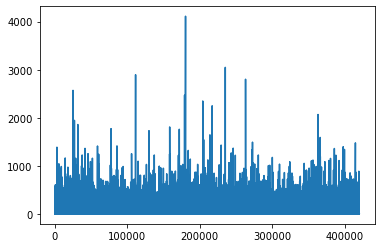

In [116]:
plt.plot(anal_data['전체_이벤트'])

(array([3.95969e+05, 1.76390e+04, 3.94500e+03, 1.29900e+03, 5.67000e+02,
        2.61000e+02, 1.47000e+02, 7.10000e+01, 5.00000e+01, 3.30000e+01,
        2.10000e+01, 1.50000e+01, 8.00000e+00, 9.00000e+00, 3.00000e+00,
        2.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000e+00, 1.03750e+02, 2.06500e+02, 3.09250e+02, 4.12000e+02,
        5.14750e+02, 6.17500e+02, 7.20250e+02, 8.23000e+02, 9.25750e+02,
        1.02850e+03, 1.13125e+03, 1.23400e+03, 1.33675e+03, 1.43950e+03,
        1.54225e+03, 1.64500e+03, 1.74775e+03, 1.85050e+03, 1.95325e+03,
        2.05600e+03, 2.15875e+03, 2.26150e+03, 2.36425e+03, 2.46700e+03,
        2.56975e+03, 2.67250e+03, 2.77525e+03, 2.

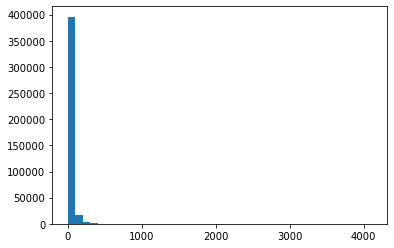

In [129]:
plt.hist(anal_data['전체_이벤트'], bins=40)


#### 드랍 추가

In [130]:
anal_data_drop=anal_data.copy()

for i in tqdm(range(len(anal_data))):
    idx=anal_data.index[i]
    if anal_data.loc[idx]['전체_이벤트']<=4.0 or anal_data.loc[idx]['전체_이벤트']>400: # 느낌만 살림
        anal_data_drop.drop([idx], inplace=True)
len(anal_data), len(anal_data_drop)

100%|██████████| 420055/420055 [27:53<00:00, 250.94it/s]


(420055, 305003)

### 군집 분석

In [131]:
#[순서]

# 1. log_data 컬럼 : 로그 변환

# 2. z-score 이상치 처리 (3)

# 3. 스케일링 : StandardScaler

# 4. PCA

# 5. 군집분석



In [132]:
anal_data_drop.describe()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트,신청_종류,신청서_갯수,신청_갯수,R,F,M
count,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,232217.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,305003.000000,232217.000000,232217.000000,232217.000000,305003.000000,305003.000000,305003.000000
mean,439746.294387,5.447140,62.257807,26.321092,1.016049,7.293014,7.733693,0.103769,0.141368,0.726250,0.717650,0.883574,0.556312,0.005774,0.716994,0.504153,0.003970,0.020674,0.900136,36.848264,2.459200,3.699884,2.149154,2.646440,2.751461,2.510959
std,253932.084574,5.826564,26.357724,24.394075,0.126445,9.497921,15.347765,0.119619,0.251668,0.746415,0.706941,1.049795,0.740056,0.082921,0.533673,0.522173,0.056062,0.126938,1.025913,46.978277,0.765729,4.396627,3.292704,1.099472,1.059725,1.099526
min,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010870,0.010870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,219863.000000,2.000000,43.000000,6.000000,1.000000,2.000000,1.000000,0.037736,0.038462,0.166667,0.250000,0.103448,0.000000,0.000000,0.200000,0.071429,0.000000,0.000000,0.285714,10.000000,2.000000,1.000000,0.000000,2.000000,2.000000,2.000000
50%,439826.000000,4.000000,70.000000,17.000000,1.000000,4.000000,1.000000,0.068182,0.076923,0.600000,0.571429,0.666667,0.375000,0.000000,0.833333,0.400000,0.000000,0.000000,0.666667,20.000000,3.000000,2.000000,1.000000,3.000000,3.000000,3.000000
75%,659476.500000,7.000000,86.000000,41.000000,1.000000,9.000000,4.000000,0.125000,0.154930,1.000000,1.000000,1.111111,0.814815,0.000000,1.000000,0.800000,0.000000,0.000000,1.000000,43.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000
max,879696.000000,90.000000,92.000000,92.000000,3.000000,295.000000,92.000000,1.000000,20.500000,27.000000,30.000000,27.000000,46.000000,7.000000,6.000000,20.000000,3.000000,6.000000,58.000000,400.000000,3.000000,72.000000,94.000000,4.000000,4.000000,4.000000


In [133]:
# 우선 anal_data 의 null 값 처리

print(anal_data_drop.isnull().sum())
print(anal_data_drop.조회_전환_시간.max()) # 최대 전환까지 걸린 기간은 92일

anal_data_drop["조회_전환_시간"] = anal_data_drop["조회_전환_시간"].fillna(100) # 전환 이력이 없는 유저에 대해서는 최대치인 92일보다 큰 100일 부여
anal_data_drop["신청_갯수"] = anal_data_drop["신청_갯수"].fillna(0)
anal_data_drop["신청서_갯수"] = anal_data_drop["신청서_갯수"].fillna(0)

print(anal_data_drop.isnull().sum())

유저_번호                      0
고유_일자                      0
첫_로그_일자                    0
마지막_로그_일자                  0
운영체제_갯수                    0
앱_실행                       0
조회_전환_시간               72786
방문일자비율                     0
앱실행비율                      0
세션당_한도조회_시작하기_버튼_클릭        0
세션당_한도조회_인트로_페이지_조회        0
세션당_한도조회_결과_확인             0
세션당_대출관리_서비스_이용            0
세션당_여윳돈_계산기_서비스_이용         0
세션당_로그인                    0
세션당_본인인증완료                 0
세션당_DSR_계산기_서비스_이용         0
세션당_회원가입                   0
세션당_KCB_신용정보_조회            0
전체_이벤트                     0
신청_종류                  72786
신청서_갯수                 72786
신청_갯수                  72786
R                          0
F                          0
M                          0
dtype: int64
92.0
유저_번호                      0
고유_일자                      0
첫_로그_일자                    0
마지막_로그_일자                  0
운영체제_갯수                    0
앱_실행                       0
조회_전환_시간                   0
방문일자비율                   

In [134]:
anal_data_drop = anal_data_drop.drop("신청_종류",axis = 1) # 신청종류 분류 애매해 drop
anal_data_drop = anal_data_drop.set_index("유저_번호")
anal_data_drop.columns


Index(['고유_일자', '첫_로그_일자', '마지막_로그_일자', '운영체제_갯수', '앱_실행', '조회_전환_시간',
       '방문일자비율', '앱실행비율', '세션당_한도조회_시작하기_버튼_클릭', '세션당_한도조회_인트로_페이지_조회',
       '세션당_한도조회_결과_확인', '세션당_대출관리_서비스_이용', '세션당_여윳돈_계산기_서비스_이용', '세션당_로그인',
       '세션당_본인인증완료', '세션당_DSR_계산기_서비스_이용', '세션당_회원가입', '세션당_KCB_신용정보_조회',
       '전체_이벤트', '신청서_갯수', '신청_갯수', 'R', 'F', 'M'],
      dtype='object')

In [135]:
anal_data_drop.to_csv("anal_data_drop.csv")

### 스펙 데이터 병합

In [136]:
spec = pd.read_csv("../data/clustering_df.csv")
spec.drop("Unnamed: 0",axis=1,inplace=True)
spec.head()

,신청서_번호,유저_번호,유저_성별,근로형태,고용형태,주거소유형태,대출희망금액,대출_목적,기대출수,기대출금액,개인회생자,신용점수등급,연소득분위,입사개월,나이,금융사_번호,상품번호,승인한도,승인금리,신청_여부(타겟)
0,1643012,397690,0.0,FREELANCER,기타,전월세,2000.0,생활비,3.0,4000.0,0,4,0,1,39,55.0,25.0,1600.0,13.1,1.0
1,1643012,397690,0.0,FREELANCER,기타,전월세,2000.0,생활비,3.0,4000.0,0,4,0,1,39,34.0,239.0,300.0,17.9,0.0
2,1643012,397690,0.0,FREELANCER,기타,전월세,2000.0,생활비,3.0,4000.0,0,4,0,1,39,35.0,29.0,300.0,15.5,1.0
3,1643012,397690,0.0,FREELANCER,기타,전월세,2000.0,생활비,3.0,4000.0,0,4,0,1,39,19.0,231.0,1000.0,15.0,0.0
4,1828364,5893,0.0,FREELANCER,기타,전월세,2000.0,생활비,3.0,4000.0,0,5,0,1,39,NaN,NaN,NaN,NaN,NaN


In [137]:
spec_num = spec[["유저_번호",'대출희망금액','기대출수', '기대출금액','신용점수등급','연소득분위', '입사개월', '나이','승인한도', '승인금리']]
spec_num_mean = spec_num.groupby("유저_번호").mean()
spec_num_mean = spec_num_mean.reset_index()
spec_num_mean.head()

,유저_번호,대출희망금액,기대출수,기대출금액,신용점수등급,연소득분위,입사개월,나이,승인한도,승인금리
0,1,500.000000,1.0,2000.0,5.000000,2.0,0.000000,22.0,NaN,NaN
1,7,1000.000000,7.0,5000.0,8.000000,2.0,35.000000,37.0,NaN,NaN
2,9,2000.000000,1.0,4000.0,4.000000,3.0,5.000000,26.0,2073.076923,11.976923
3,11,596.153846,1.0,1000.0,6.480769,3.0,10.596154,25.0,1638.000000,16.014000
4,12,0.000000,5.5,2000.0,9.000000,4.0,7.857143,31.0,NaN,NaN


In [138]:
spec_cat_raw = spec[["유저_번호",'유저_성별', '대출_목적','근로형태', '고용형태', '주거소유형태']]
spec_cat_raw.head()

,유저_번호,유저_성별,대출_목적,근로형태,고용형태,주거소유형태
0,397690,0.0,생활비,FREELANCER,기타,전월세
1,397690,0.0,생활비,FREELANCER,기타,전월세
2,397690,0.0,생활비,FREELANCER,기타,전월세
3,397690,0.0,생활비,FREELANCER,기타,전월세
4,5893,0.0,생활비,FREELANCER,기타,전월세


In [139]:
spec_cat_raw.대출_목적.unique()

array(['생활비', '사업자금', '기타', '대환대출', '전월세보증금', '주택구입', '투자', '자동차구입',
       'LIVING', 'SWITCHLOAN', 'ETC', 'INVEST', 'HOUSEDEPOSIT',
       'BUSINESS', 'BUYCAR', 'BUYHOUSE'], dtype=object)

In [140]:
# 범주형 변수의 항목 매핑/변환에 사용할 기준 정보를 dict 자료형으로 만들기
name_mapping = {
                    "LIVING" : "생활비",
                    "SWITCHLOAN" : "대환대출" ,
                    "ETC" : "기타" ,
                    "INVEST" : "투자",
                    "HOUSEDEPOSIT" : "전월세보증금" ,
                    "BUSINESS" : "사업자금", 
                    "BUYCAR" : "자동차구입" ,
                    'BUYHOUSE' : "주택구입" ,
                } 

# dict.get() 함수를 이용하여 매핑/변환에 사용할 사용자 정의 함수 만들기
func = lambda x: name_mapping.get(x, x)

In [141]:
# map() 함수로 매핑용 사용자 정의 함수를 DataFrame의 범주형 변수에 적용하여 매핑/변환하기
spec_cat_raw["대출_목적"] =  spec_cat_raw.대출_목적.map(func)

/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [142]:
# 범주형 변수는 최빈값으로 집계
spec_cat = pd.DataFrame(columns=["유저_번호","유저_성별","대출_목적","근로형태","고용형태","주거소유형태"])
spec_cat["유저_번호"] = spec_cat_raw["유저_번호"].unique()

for i in tqdm(spec_cat_raw.columns[1:]):
    a = spec_cat_raw.groupby('유저_번호')[[str(i)]].agg({lambda x:x.mode()}).reset_index()
    a.columns = a.columns.droplevel(1)
    spec_cat[str(i)] = a[str(i)]

spec_cat.head()

100%|██████████| 5/5 [01:58<00:00, 23.61s/it]


,유저_번호,유저_성별,대출_목적,근로형태,고용형태,주거소유형태
0,397690,1.0,생활비,OTHERINCOME,기타,전월세
1,5893,1.0,생활비,EARNEDINCOME2,계약직,기타가족소유
2,104260,1.0,사업자금,EARNEDINCOME,계약직,기타가족소유
3,91141,1.0,대환대출,EARNEDINCOME,정규직,기타가족소유
4,60305,1.0,생활비,EARNEDINCOME,정규직,기타가족소유


In [143]:
#최빈값이 2개 이상인 경우 가장 앞의 값으로 대체

col = ["근로형태","고용형태","주거소유형태","대출_목적"]
for col in col:
    for i in tqdm(range(0,(len(spec_cat)))):
        try:
            col_shape = spec_cat[str(col)][i].shape
            t = list(spec_cat[str(col)][i].shape)[0]
            u = spec_cat["유저_번호"][i]
            spec_cat.loc[spec_cat["유저_번호"]==u,str(col)] = spec_cat[str(col)][i][t-1]
        except AttributeError :
            continue

100%|██████████| 405196/405196 [00:44<00:00, 9126.07it/s] 


In [144]:
spec_num_mean.head()


,유저_번호,대출희망금액,기대출수,기대출금액,신용점수등급,연소득분위,입사개월,나이,승인한도,승인금리
0,1,500.000000,1.0,2000.0,5.000000,2.0,0.000000,22.0,NaN,NaN
1,7,1000.000000,7.0,5000.0,8.000000,2.0,35.000000,37.0,NaN,NaN
2,9,2000.000000,1.0,4000.0,4.000000,3.0,5.000000,26.0,2073.076923,11.976923
3,11,596.153846,1.0,1000.0,6.480769,3.0,10.596154,25.0,1638.000000,16.014000
4,12,0.000000,5.5,2000.0,9.000000,4.0,7.857143,31.0,NaN,NaN


In [145]:
# 성별의 경우 0,1 동시에 있는 경우 0으로 대체

for i in tqdm(range(0,(len(spec_cat)))):

    
    try : 
        a = spec_cat["유저_성별"][i].shape
        print(list(a)[0])
        print(i)
        u = spec_cat["유저_번호"][i]
        spec_cat.loc[spec_cat["유저_번호"]==u,"유저_성별"] = 0
    except :
        continue

# list([0,1])[0]

 11%|█         | 45170/405196 [00:00<00:01, 231269.06it/s]

2
2594
2
4362
2
6167
2
7723
2
10858
2
20405
2
35128
2
45665


 25%|██▍       | 100062/405196 [00:00<00:01, 262336.01it/s]

2
49380
2
107606


 45%|████▍     | 181671/405196 [00:00<00:00, 265457.94it/s]

2
137997
2
174783
2
180826
2
193248


 59%|█████▊    | 237660/405196 [00:00<00:00, 266531.07it/s]

2
203541
2
206293
2
207098


 72%|███████▏  | 292084/405196 [00:01<00:00, 266701.18it/s]

2
260719
2
266914
2
280210


 93%|█████████▎| 378438/405196 [00:01<00:00, 280439.03it/s]

2
342502
2
382408
2
393688
2
394502


100%|██████████| 405196/405196 [00:01<00:00, 263762.42it/s]

2
397055


In [146]:
for col in (spec_cat.columns):
    spec_cat[str(col)] = list(spec_cat[str(col)])

In [147]:
spec_cat_mode = spec_cat

In [148]:
spec_cat_mode.head()

,유저_번호,유저_성별,대출_목적,근로형태,고용형태,주거소유형태
0,397690,1.0,생활비,OTHERINCOME,기타,전월세
1,5893,1.0,생활비,EARNEDINCOME2,계약직,기타가족소유
2,104260,1.0,사업자금,EARNEDINCOME,계약직,기타가족소유
3,91141,1.0,대환대출,EARNEDINCOME,정규직,기타가족소유
4,60305,1.0,생활비,EARNEDINCOME,정규직,기타가족소유


In [149]:
spec_num_mean = spec_num_mean.reset_index(drop=True) # 수치형 데이터는 평균으로 집계

user_spec_pre = pd.merge(spec_num_mean, spec_cat_mode, on="유저_번호", how="inner")
user_spec_pre

,유저_번호,대출희망금액,기대출수,기대출금액,신용점수등급,연소득분위,입사개월,나이,승인한도,승인금리,유저_성별,대출_목적,근로형태,고용형태,주거소유형태
0,1,500.000000,1.0,2000.0,5.000000,2.0,0.000000,22.0,NaN,NaN,0.0,생활비,EARNEDINCOME,정규직,전월세
1,7,1000.000000,7.0,5000.0,8.000000,2.0,35.000000,37.0,NaN,NaN,0.0,생활비,FREELANCER,기타,기타가족소유
2,9,2000.000000,1.0,4000.0,4.000000,3.0,5.000000,26.0,2073.076923,11.976923,1.0,생활비,EARNEDINCOME,정규직,전월세
3,11,596.153846,1.0,1000.0,6.480769,3.0,10.596154,25.0,1638.000000,16.014000,1.0,대환대출,EARNEDINCOME,정규직,자가
4,12,0.000000,5.5,2000.0,9.000000,4.0,7.857143,31.0,NaN,NaN,0.0,생활비,OTHERINCOME,기타,전월세
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405191,879693,0.000000,3.0,2000.0,6.100000,2.0,8.100000,21.0,1350.000000,17.711111,0.0,생활비,PRIVATEBUSINESS,정규직,전월세
405192,879694,1000.000000,4.0,8000.0,7.000000,5.0,31.000000,31.0,NaN,NaN,1.0,생활비,EARNEDINCOME,정규직,전월세
405193,879695,2000.000000,4.0,3000.0,7.000000,3.0,4.000000,26.0,1240.000000,13.900000,0.0,생활비,EARNEDINCOME2,정규직,전월세
405194,879696,1000.000000,3.0,2000.0,7.000000,4.0,6.000000,25.0,1168.750000,11.562500,1.0,생활비,FREELANCER,기타,자가


In [150]:
print(len(spec_cat_mode))
print(len(spec_num_mean)) # 405196

405196
405196


In [151]:
# 수치형 데이터 범주형 데이터 병합
spec_pre = pd.merge(spec_num_mean, spec_cat_mode, on = "유저_번호", how = "inner")
spec_pre

,유저_번호,대출희망금액,기대출수,기대출금액,신용점수등급,연소득분위,입사개월,나이,승인한도,승인금리,유저_성별,대출_목적,근로형태,고용형태,주거소유형태
0,1,500.000000,1.0,2000.0,5.000000,2.0,0.000000,22.0,NaN,NaN,0.0,생활비,EARNEDINCOME,정규직,전월세
1,7,1000.000000,7.0,5000.0,8.000000,2.0,35.000000,37.0,NaN,NaN,0.0,생활비,FREELANCER,기타,기타가족소유
2,9,2000.000000,1.0,4000.0,4.000000,3.0,5.000000,26.0,2073.076923,11.976923,1.0,생활비,EARNEDINCOME,정규직,전월세
3,11,596.153846,1.0,1000.0,6.480769,3.0,10.596154,25.0,1638.000000,16.014000,1.0,대환대출,EARNEDINCOME,정규직,자가
4,12,0.000000,5.5,2000.0,9.000000,4.0,7.857143,31.0,NaN,NaN,0.0,생활비,OTHERINCOME,기타,전월세
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405191,879693,0.000000,3.0,2000.0,6.100000,2.0,8.100000,21.0,1350.000000,17.711111,0.0,생활비,PRIVATEBUSINESS,정규직,전월세
405192,879694,1000.000000,4.0,8000.0,7.000000,5.0,31.000000,31.0,NaN,NaN,1.0,생활비,EARNEDINCOME,정규직,전월세
405193,879695,2000.000000,4.0,3000.0,7.000000,3.0,4.000000,26.0,1240.000000,13.900000,0.0,생활비,EARNEDINCOME2,정규직,전월세
405194,879696,1000.000000,3.0,2000.0,7.000000,4.0,6.000000,25.0,1168.750000,11.562500,1.0,생활비,FREELANCER,기타,자가


In [152]:
# 기존 anal 데이터와 스펙 데이터 병합
anal_data_ = anal_data_drop.reset_index()
merge_total = pd.merge(anal_data_ ,spec_pre, on ="유저_번호", how="left")
merge_total = merge_total.drop(["승인한도", "승인금리"], axis = 1)

In [153]:
spec_pre["대출_목적"].value_counts()

생활비       245792
대환대출       95905
사업자금       24322
전월세보증금     13621
주택구입       10282
기타          8971
투자          4862
자동차구입       1441
Name: 대출_목적, dtype: int64

In [154]:
# 범주형 데이터 인코딩
import category_encoders as ce
from category_encoders import BinaryEncoder

# 이진분류 인코딩
merge_total_enc = BinaryEncoder(cols=['근로형태', '고용형태',"주거소유형태","대출_목적"]).fit_transform(merge_total)

In [155]:
merge_total_enc 

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,...,나이,유저_성별,대출_목적_0,대출_목적_1,대출_목적_2,대출_목적_3,근로형태_0,근로형태_1,근로형태_2,고용형태_0,고용형태_1,고용형태_2,주거소유형태_0,주거소유형태_1,주거소유형태_2
0,11,2,69,42,1,3.0,1.0,0.028986,0.043478,0.666667,1.000000,1.666667,2.333333,0.333333,0.000000,...,25.0,1.0,0,0,0,1,0,0,1,0,0,1,0,0,1
1,12,10,79,13,1,11.0,1.0,0.126582,0.139241,1.000000,1.000000,2.181818,0.090909,0.000000,1.000000,...,31.0,0.0,0,0,1,0,0,1,0,0,1,0,0,1,0
2,17,2,87,86,1,3.0,1.0,0.022989,0.034483,1.666667,1.000000,1.333333,0.333333,0.000000,0.000000,...,29.0,1.0,0,0,1,0,0,1,1,0,0,1,0,1,0
3,20,9,79,9,1,13.0,1.0,0.113924,0.164557,0.692308,0.692308,0.692308,0.000000,0.000000,0.615385,...,33.0,1.0,0,0,1,0,0,0,1,0,0,1,0,0,1
4,21,4,44,28,1,5.0,100.0,0.090909,0.113636,0.200000,0.200000,0.000000,0.400000,0.000000,0.800000,...,NaN,NaN,0,0,1,1,1,0,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304998,879689,6,57,8,1,8.0,1.0,0.105263,0.140351,1.000000,1.375000,0.875000,1.000000,0.000000,0.000000,...,33.0,0.0,0,0,1,0,0,1,0,0,1,0,0,1,0
304999,879691,6,92,79,1,15.0,1.0,0.065217,0.163043,1.000000,0.400000,0.866667,0.000000,0.000000,1.000000,...,31.0,1.0,0,0,1,0,0,1,1,1,0,0,1,0,0
305000,879692,4,44,37,1,5.0,1.0,0.090909,0.113636,1.000000,1.200000,1.400000,1.200000,0.000000,1.200000,...,30.0,1.0,0,1,1,1,0,1,1,1,0,1,0,1,0
305001,879693,3,19,12,1,4.0,1.0,0.157895,0.210526,3.000000,1.250000,2.250000,0.750000,0.000000,0.000000,...,21.0,0.0,0,0,1,0,1,0,1,0,0,1,0,1,0


In [156]:
merge_total_enc.to_csv("merge_total_enc_drop.csv")

### 경로 데이터 병합

In [157]:
route_data = pd.read_csv("../data/extra_data_add_route_.csv", index_col = 0)
route_df = route_data.drop(route_data.iloc[:,1:26], axis=1)
route_df

,유저_번호,UG,GU,GV,UV,VG,UGV,GUV,VU,VUG,VGU,UVG,GVU,funnel_01,funnel_10,funnel_21,funnel_32,funnel_10_hesitate_mean,funnel_21_hesitate_sec_mean,funnel_32_hesitate_sec_mean
0,11,3,4,0,1,1,0,1,0,0,1,0,0,0,3,3,4,0.0,30.5,156.5
1,12,1,1,1,0,0,0,0,0,0,0,0,0,11,4,3,14,0.0,22.5,158.5
2,17,1,1,1,0,0,1,0,0,0,0,0,0,0,2,1,1,1.0,20.0,199.0
3,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,24.0,65.0
4,20,0,0,0,0,0,0,0,0,0,0,0,0,4,3,3,5,0.0,27.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420050,879693,2,0,1,1,0,1,0,1,1,0,0,0,5,5,2,2,0.0,17.5,263.0
420051,879694,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,19.0,1000.0
420052,879695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,19.0,152.0
420053,879696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.0,-1.0,-1.0


In [158]:
# import pandas as pd

merge_route = pd.merge(merge_total_enc, route_df, on = "유저_번호", how = "left")

In [159]:
merge_route.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,...,VG,UGV,GUV,VU,VUG,VGU,UVG,GVU,funnel_01,funnel_10,funnel_21,funnel_32,funnel_10_hesitate_mean,funnel_21_hesitate_sec_mean,funnel_32_hesitate_sec_mean
0,11,2,69,42,1,3.0,1.0,0.028986,0.043478,0.666667,1.000000,1.666667,2.333333,0.333333,0.000000,...,1,0,1,0,0,1,0,0,0,3,3,4,0.0,30.5,156.5
1,12,10,79,13,1,11.0,1.0,0.126582,0.139241,1.000000,1.000000,2.181818,0.090909,0.000000,1.000000,...,0,0,0,0,0,0,0,0,11,4,3,14,0.0,22.5,158.5
2,17,2,87,86,1,3.0,1.0,0.022989,0.034483,1.666667,1.000000,1.333333,0.333333,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,2,1,1,1.0,20.0,199.0
3,20,9,79,9,1,13.0,1.0,0.113924,0.164557,0.692308,0.692308,0.692308,0.000000,0.000000,0.615385,...,0,0,0,0,0,0,0,0,4,3,3,5,0.0,27.0,104.0
4,21,4,44,28,1,5.0,100.0,0.090909,0.113636,0.200000,0.200000,0.000000,0.400000,0.000000,0.800000,...,1,0,0,0,0,1,0,0,1,0,0,0,0.0,-1.0,-1.0


In [160]:
merge_route.isnull().sum()

유저_번호                          0
고유_일자                          0
첫_로그_일자                        0
마지막_로그_일자                      0
운영체제_갯수                        0
                              ..
funnel_21                      0
funnel_32                      0
funnel_10_hesitate_mean        0
funnel_21_hesitate_sec_mean    0
funnel_32_hesitate_sec_mean    0
Length: 65, dtype: int64

In [161]:
len(merge_route.columns)

65

In [162]:
merge_route.to_csv("merge_route_drop.csv")

In [163]:
pd.set_option('display.max_rows', 50)
merge_route.isnull().sum()

유저_번호                          0
고유_일자                          0
첫_로그_일자                        0
마지막_로그_일자                      0
운영체제_갯수                        0
                              ..
funnel_21                      0
funnel_32                      0
funnel_10_hesitate_mean        0
funnel_21_hesitate_sec_mean    0
funnel_32_hesitate_sec_mean    0
Length: 65, dtype: int64

- 스펙 데이터가 있는 데이터, 없는 데이터 분리

In [173]:
spec_not_data = merge_route[merge_route["대출희망금액"].isnull()]
spec_not_data = spec_not_data.drop(spec_not_data.iloc[:,25:46], axis =1)
spec_not_data.to_csv("spec_not_data.csv")

In [165]:
spec_in_data = merge_route[merge_route["대출희망금액"] >= 0]
spec_in_data
# spec_in_data.to_csv("spec_in_data.csv")

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,조회_전환_시간,방문일자비율,앱실행비율,세션당_한도조회_시작하기_버튼_클릭,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,...,VG,UGV,GUV,VU,VUG,VGU,UVG,GVU,funnel_01,funnel_10,funnel_21,funnel_32,funnel_10_hesitate_mean,funnel_21_hesitate_sec_mean,funnel_32_hesitate_sec_mean
0,11,2,69,42,1,3.0,1.0,0.028986,0.043478,0.666667,1.000000,1.666667,2.333333,0.333333,0.000000,...,1,0,1,0,0,1,0,0,0,3,3,4,0.0,30.5,156.5
1,12,10,79,13,1,11.0,1.0,0.126582,0.139241,1.000000,1.000000,2.181818,0.090909,0.000000,1.000000,...,0,0,0,0,0,0,0,0,11,4,3,14,0.0,22.5,158.5
2,17,2,87,86,1,3.0,1.0,0.022989,0.034483,1.666667,1.000000,1.333333,0.333333,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,2,1,1,1.0,20.0,199.0
3,20,9,79,9,1,13.0,1.0,0.113924,0.164557,0.692308,0.692308,0.692308,0.000000,0.000000,0.615385,...,0,0,0,0,0,0,0,0,4,3,3,5,0.0,27.0,104.0
5,24,2,19,16,1,1.0,4.0,0.105263,0.052632,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0.0,36.0,558.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304998,879689,6,57,8,1,8.0,1.0,0.105263,0.140351,1.000000,1.375000,0.875000,1.000000,0.000000,0.000000,...,1,1,1,1,1,0,0,0,3,3,2,4,1.0,60.0,1000.0
304999,879691,6,92,79,1,15.0,1.0,0.065217,0.163043,1.000000,0.400000,0.866667,0.000000,0.000000,1.000000,...,1,0,0,0,0,0,0,0,3,3,3,4,0.0,35.0,158.5
305000,879692,4,44,37,1,5.0,1.0,0.090909,0.113636,1.000000,1.200000,1.400000,1.200000,0.000000,1.200000,...,1,0,2,0,0,0,0,0,1,1,1,3,1.0,41.0,143.0
305001,879693,3,19,12,1,4.0,1.0,0.157895,0.210526,3.000000,1.250000,2.250000,0.750000,0.000000,0.000000,...,0,1,0,1,1,0,0,0,5,5,2,2,0.0,17.5,263.0


# 드랍각
- 못살림

In [166]:
desc_df=spec_in_data.describe()
min_zero_cols=[]
for col in desc_df.columns:
    if desc_df.loc['min'][col]==0.0 and desc_df.loc['25%'][col]==0.0: min_zero_cols.append(col)
    
spec_in_data[min_zero_cols].describe()


,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_DSR_계산기_서비스_이용,세션당_회원가입,신청_갯수,유저_성별,대출_목적_0,대출_목적_1,대출_목적_2,대출_목적_3,근로형태_0,근로형태_1,고용형태_0,고용형태_1,...,UG,GU,GV,UV,VG,UGV,GUV,VU,VUG,VGU,UVG,GVU,funnel_01,funnel_10,funnel_21
count,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,...,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000
mean,0.532006,0.005557,0.729991,0.003604,0.015440,2.095814,0.665691,0.015408,0.141580,0.698938,0.300252,0.215956,0.307470,0.087088,0.291240,...,2.128658,1.759066,0.659001,0.351182,0.303355,0.282102,0.222973,0.125798,0.063445,0.053169,0.033272,0.016634,2.361437,1.755345,1.261856
std,0.698246,0.077498,0.536387,0.051813,0.100996,3.268731,0.471749,0.123168,0.348619,0.458721,0.458368,0.411485,0.461447,0.281965,0.454335,...,4.268875,3.580145,1.240797,0.784055,0.741768,0.672174,0.578570,0.441783,0.282154,0.255951,0.196509,0.138732,3.582915,2.760224,2.121205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.357143,0.000000,0.857143,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.750000,0.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.000000
max,46.000000,6.000000,6.000000,3.000000,4.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,137.000000,125.000000,39.000000,21.000000,27.000000,22.000000,16.000000,18.000000,8.000000,9.000000,6.000000,5.000000,66.000000,56.000000,41.000000


In [167]:
# spec_in_data['min_sum']=0
# for col in min_zero_cols:
#     spec_in_data['min_sum']+=spec_in_data[col]
# spec_in_data['min_sum'].describe()

/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nkeum/opt/anaconda3/envs/smartfarm/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count    238127.000000
mean         19.180663
std          16.831388
min           3.000000
25%           9.000000
50%          13.818182
75%          23.000000
max         316.372093
Name: min_sum, dtype: float64

### (1) 로그화

In [174]:
spec_not_data[['운영체제_갯수', 'VUG', 'VGU', 'UVG', 'GVU']].describe()

,운영체제_갯수,VUG,VGU,UVG,GVU
count,66876.000000,66876.000000,66876.000000,66876.000000,66876.000000
mean,1.009211,0.026811,0.028456,0.013323,0.009121
std,0.096776,0.177245,0.182069,0.122108,0.099527
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,5.000000,8.000000,5.000000,3.000000


In [168]:
spec_in_data[['운영체제_갯수', '대출_목적_0', 'VUG', 'VGU', 'UVG', 'GVU']].describe()


,운영체제_갯수,대출_목적_0,VUG,VGU,UVG,GVU
count,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000,238127.000000
mean,1.017969,0.015408,0.063445,0.053169,0.033272,0.016634
std,0.133534,0.123168,0.282154,0.255951,0.196509,0.138732
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,1.000000,8.000000,9.000000,6.000000,5.000000


In [175]:
# 왜도 3 이상인 설명변수 log1p 변환

spec_not_data_log = spec_not_data.set_index("유저_번호").copy()
spec_in_data_log = spec_in_data.set_index("유저_번호").copy()

no_log_col_list = ['운영체제_갯수', '대출_목적_0', 'VUG', 'VGU', 'UVG', 'GVU']

for val in spec_not_data_log.columns:
    if val in no_log_col_list: continue
    spec_not_data_log[val] = spec_not_data_log[val]+1
    if abs(spec_not_data_log[val].skew()) > 3:
        spec_not_data_log[val] = np.log1p(spec_not_data_log[val]+1)
        
for val in spec_in_data_log.columns:
    if val in no_log_col_list: continue
    spec_in_data_log[val] = spec_in_data_log[val]+1
    if abs(spec_in_data_log[val].skew()) > 3:
        spec_in_data_log[val] = np.log1p(spec_in_data_log[val]+1)

### (2) z-score 이상치 처리 

In [176]:
print(len(spec_not_data)) # 처리 이전 데이터 
print(len(spec_in_data))

66876
238127


In [99]:
# def std_based_outlier(df):
#     for i in range(0, len(df.iloc[1])): 
#         df.iloc[:,i] = df.iloc[:,i].replace(0, np.NaN) # optional
#         df = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3.5*df.iloc[:,i].std()))].fillna(0)
#     return df

In [100]:
# spec_not_data_log = std_based_outlier(spec_not_data_log.copy())
# spec_in_data_log = std_based_outlier(spec_in_data_log.copy())

In [101]:
# print(len(spec_not_data_log)) # 처리 후 데이터
# print(len(spec_in_data_log))

In [102]:
# spec_in_data_log

### (3) 표준화

In [177]:
# 표준화
from sklearn.preprocessing import StandardScaler

spec_not_std_data = spec_not_data_log.copy()
spec_in_std_data = spec_in_data_log.copy()

spec_not_std_data
def standardize_by_col(df):
    result = df.copy()
    for feature_name in df.columns:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

# 차선책
def normalize_by_col(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (
            df[feature_name] - min_value) / (max_value - min_value)
    return result

spec_not_std = standardize_by_col(spec_not_std_data)
spec_not_std  = pd.DataFrame(spec_not_std)

spec_in_std = standardize_by_col(spec_in_std_data)
spec_in_std  = pd.DataFrame(spec_in_std)

spec_not_std.columns= spec_not_std_data.columns.copy()
spec_in_std.columns= spec_in_std_data.columns.copy()

spec_not_std = spec_not_std.set_index(spec_not_data_log.index)
spec_in_std = spec_in_std.set_index(spec_in_data_log.index)

# print(round(spec_in_std.describe(),2))
# print(round(spec_not_std.describe(),2))

<AxesSubplot:>

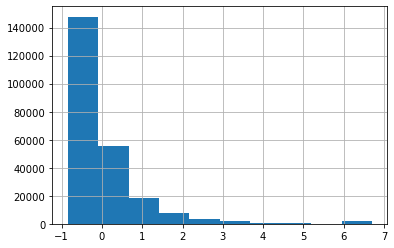

In [178]:
spec_not_std.to_csv("../data/spec_not_std_drop.csv")
spec_in_std.to_csv("../data/spec_in_std_drop.csv")
spec_in_std["방문일자비율"].hist()